# **SVM CLASSIFIER**



### **PREPROCESS**

---



In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [3]:
from google.colab import files
import pandas as pd

# Step 1: Upload the CSV file from your computer
uploaded = files.upload()

# Step 2: Read the uploaded CSV file
filename = list(uploaded.keys())[0]   # gets the uploaded filename automatically
df = pd.read_csv(filename)

# Step 3: Check the data
print("File uploaded successfully:", filename)
print("Shape:", df.shape)
df.head()


Saving student_depression_dataset.csv to student_depression_dataset.csv
File uploaded successfully: student_depression_dataset.csv
Shape: (27901, 18)


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33,Visakhapatnam,Student,5,0,8.97,2,0,'5-6 hours',Healthy,B.Pharm,Yes,3,1,No,1
1,8,Female,24,Bangalore,Student,2,0,5.90,5,0,'5-6 hours',Moderate,BSc,No,3,2,Yes,0
2,26,Male,31,Srinagar,Student,3,0,7.03,5,0,'Less than 5 hours',Healthy,BA,No,9,1,Yes,0
3,30,Female,28,Varanasi,Student,3,0,5.59,2,0,'7-8 hours',Moderate,BCA,Yes,4,5,Yes,1
4,32,Female,25,Jaipur,Student,4,0,8.13,3,0,'5-6 hours',Moderate,M.Tech,Yes,1,1,No,0


In [4]:
# Load the dataset and replace placeholder '?' with NaN
df = pd.read_csv("student_depression_dataset.csv")

In [5]:
# Drop irrelevant/high-cardinality columns
df = df.drop(columns=['id', 'City', 'Profession'])
print(f"Data Shape After Dropping Columns: {df.shape}")

Data Shape After Dropping Columns: (27901, 15)


**Handling missing values**

In [6]:
# Handle missing values (Imputation)
df['Financial Stress'] = df['Financial Stress'].replace('?', np.nan).astype(float)
df['Work/Study Hours'] = df['Work/Study Hours'].replace('?', np.nan)
df['Work/Study Hours'] = pd.to_numeric(df['Work/Study Hours'], errors='coerce')

if df['Financial Stress'].isna().any() or df['Work/Study Hours'].isna().any():
    df['Financial Stress'] = df['Financial Stress'].fillna(df['Financial Stress'].median())
    df['Work/Study Hours'] = df['Work/Study Hours'].fillna(df['Work/Study Hours'].median())
    print('Step 3: Missing values handled with median imputation.')

Step 3: Missing values handled with median imputation.


In [7]:
# Rename target variable for clarity
df = df.rename(columns={'Depression': 'Depression_Target'})
print('Step 4: Target variable renamed.')


Step 4: Target variable renamed.


**Outlier removal**

In [8]:
# Outlier Removal Preparation
# Identify numerical columns
numerical_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

# Define the outlier detection function (using IQR method)
def detect_outliers_iqr(df_in, column):
    """Calculates the IQR fences for a column."""
    Q1 = df_in[column].quantile(0.25)
    Q3 = df_in[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Outlier Removal (Applied to df_cleaned)
df_cleaned = df.copy()
initial_rows = len(df_cleaned)

for col in numerical_cols:
    lower, upper = detect_outliers_iqr(df_cleaned, col)
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]

rows_removed = initial_rows - len(df_cleaned)
print(f"\nTotal rows after outlier removal: {len(df_cleaned)}")



Total rows after outlier removal: 27878


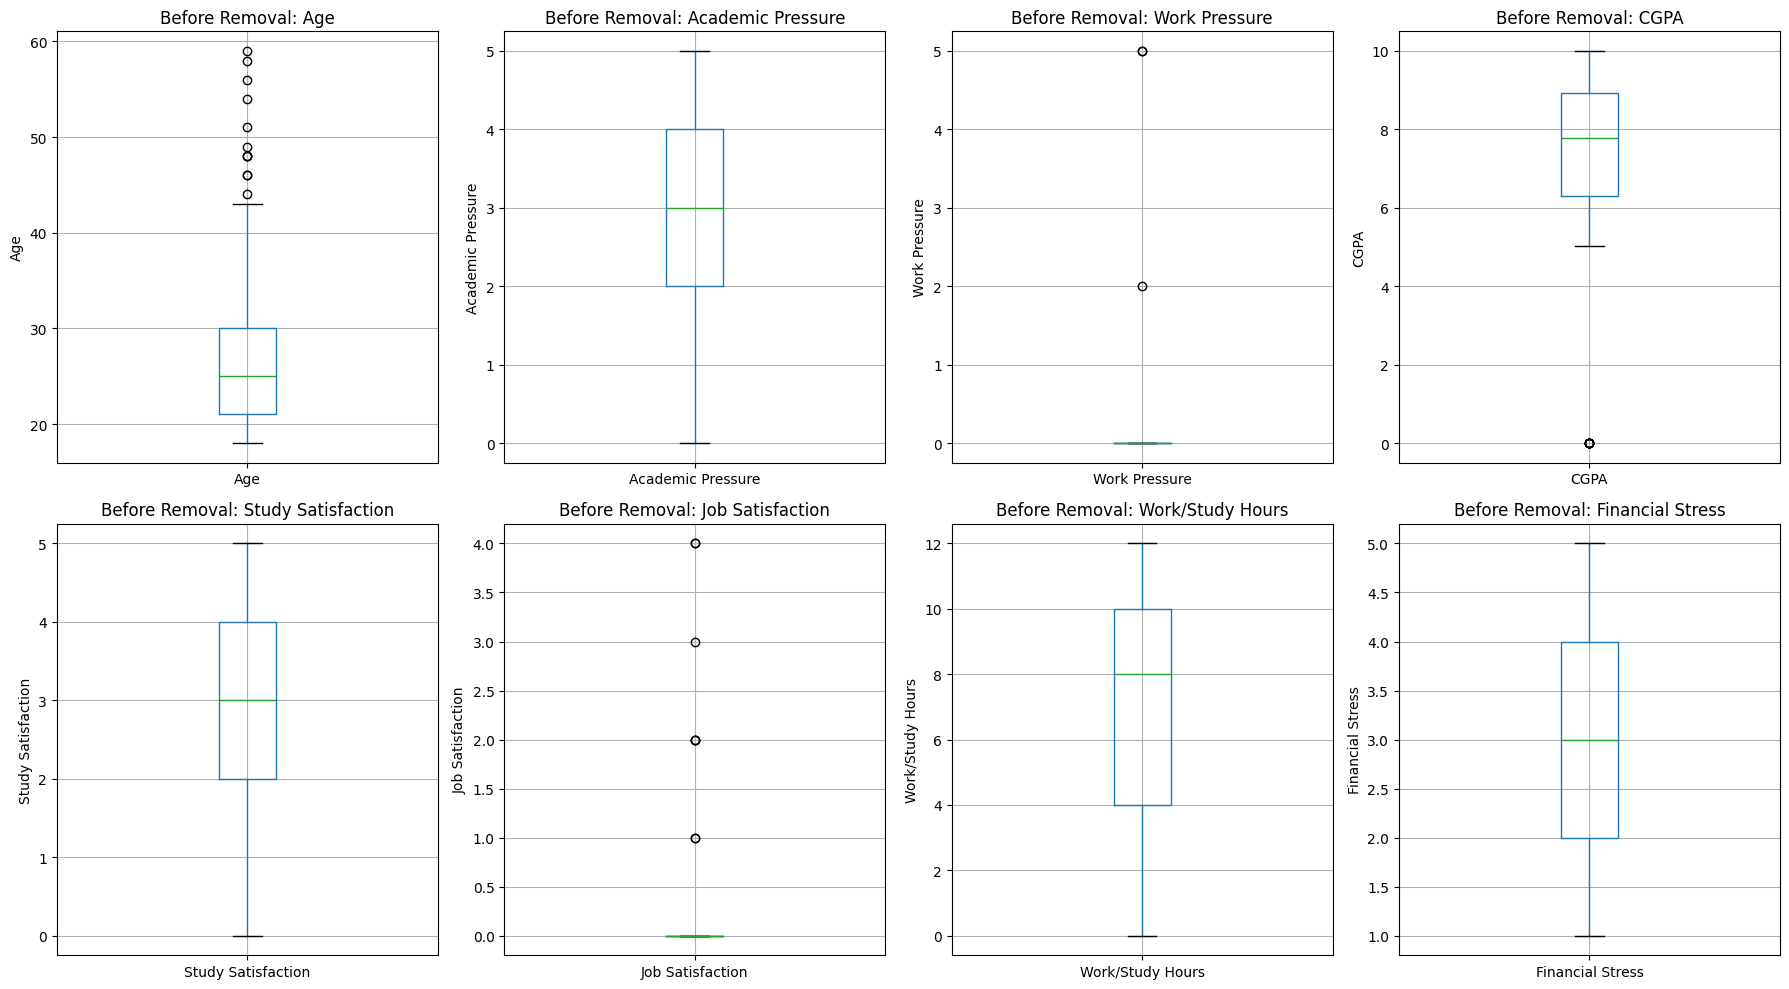

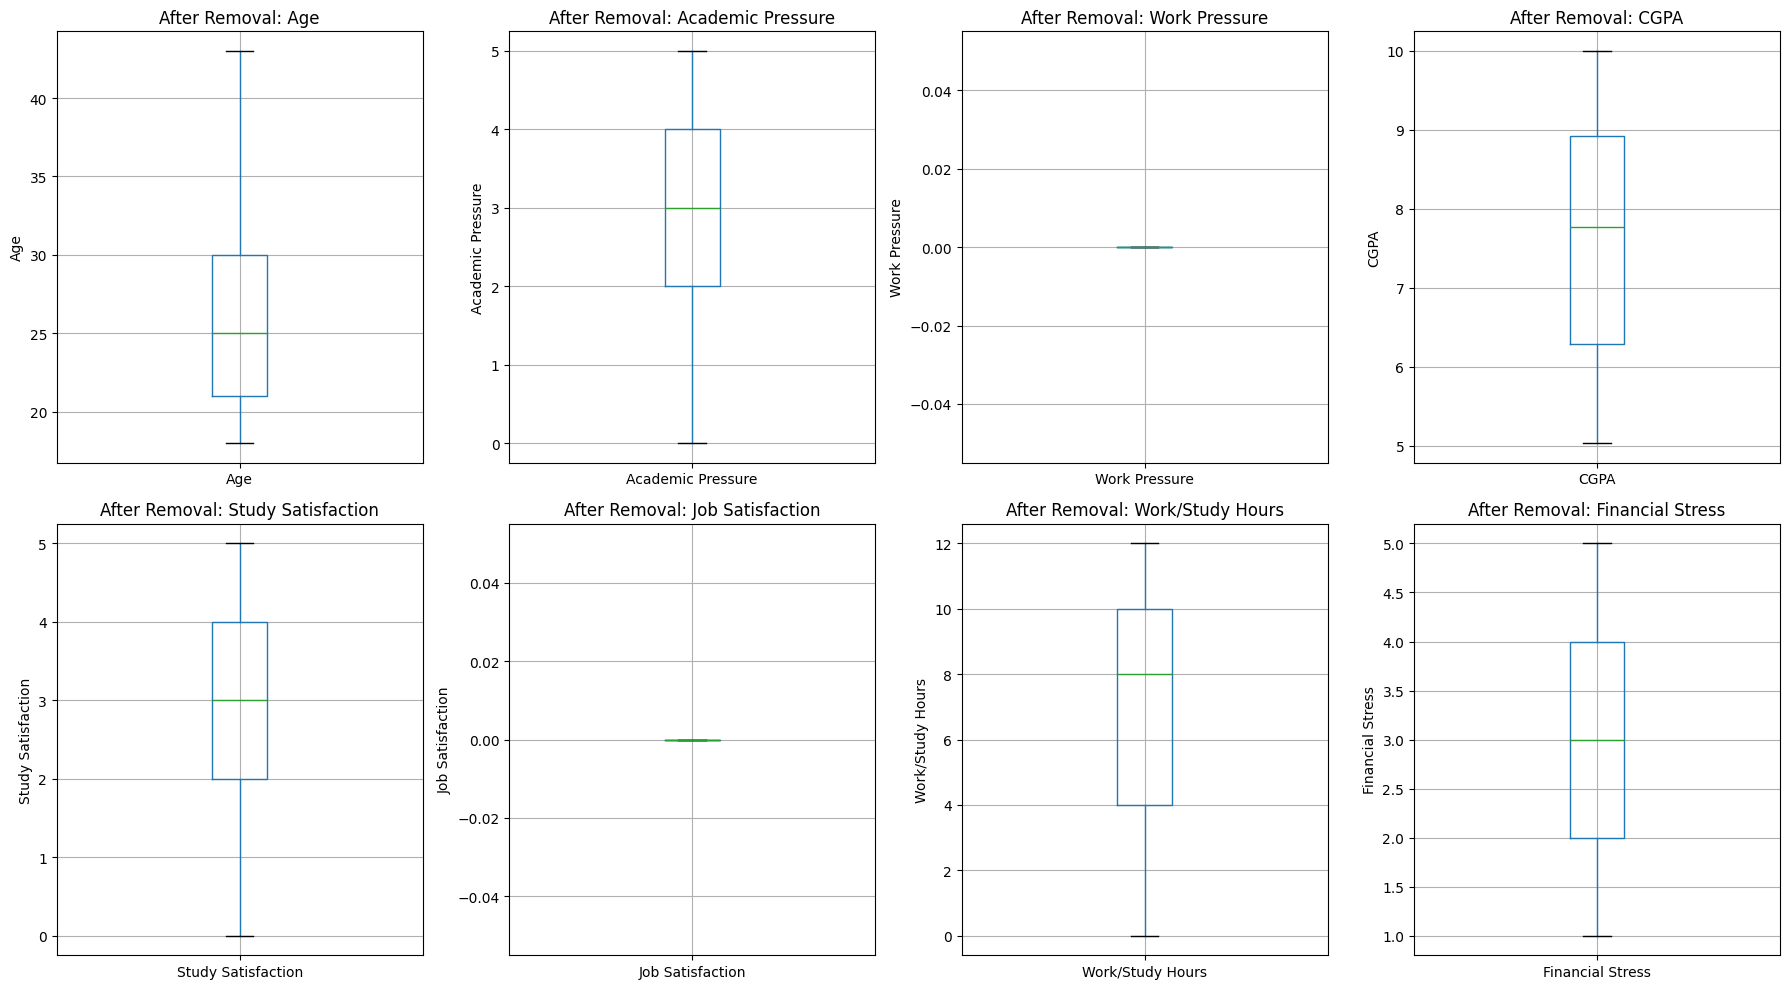

In [9]:

# Box Plots BEFORE Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df.boxplot(column=col)
    plt.title(f'Before Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_before_outlier_removal.png')
plt.close()

# Box Plots AFTER Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df_cleaned.boxplot(column=col)
    plt.title(f'After Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_after_outlier_removal.png')
plt.close()


**Encoding categorical data**

In [10]:
# --- Encoding Categorical Variables on CLEANED data ---
df_encoded = df_cleaned.copy()

# Binary Encoding and dropping original columns
binary_mapping = {
    'Gender': {'Male': 0, 'Female': 1},
    'Have you ever had suicidal thoughts ?': {'No': 0, 'Yes': 1},
    'Family History of Mental Illness': {'No': 0, 'Yes': 1}
}
binary_cols_to_drop = []

for original_col, mapping in binary_mapping.items():
    encoded_col = original_col.replace(' ', '_').replace('?', '').strip() + '_Encoded'
    if original_col in df_encoded.columns:
        # Impute NaNs in original column with mode before mapping
        df_encoded[original_col] = df_encoded[original_col].fillna(df_encoded[original_col].mode()[0])
        df_encoded[encoded_col] = df_encoded[original_col].map(mapping)
        binary_cols_to_drop.append(original_col)

df_encoded = df_encoded.drop(columns=binary_cols_to_drop)
print('Binary categorical variables encoded and original columns dropped.')


# One-Hot Encoding
categorical_cols = ['Degree', 'Sleep Duration', 'Dietary Habits']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, dtype=int)
print('Nominal categorical variables one-hot encoded.')

# Save the encoded data for the feature selection step
df_encoded.to_csv('student_depression_dataset_encoded.csv', index=False)

Binary categorical variables encoded and original columns dropped.
Nominal categorical variables one-hot encoded.


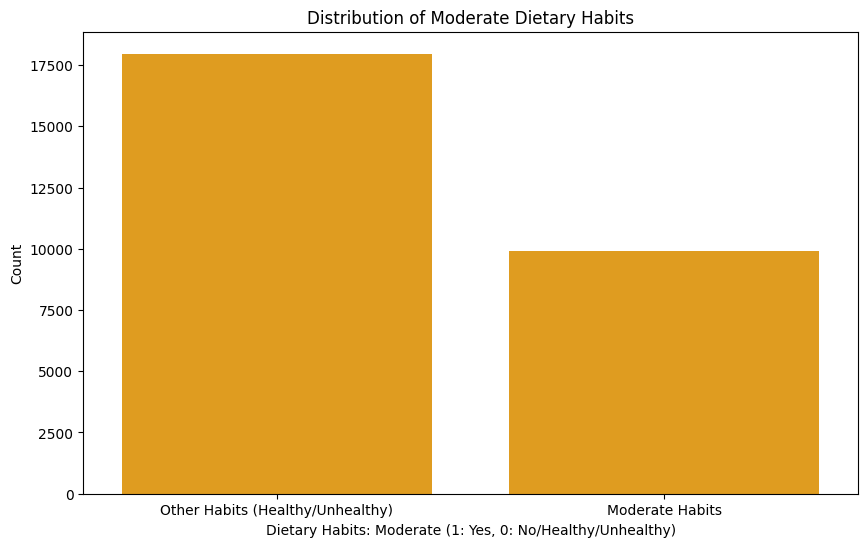

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create bar chart
plt.figure(figsize=(10, 6))
# Use one of your one-hot encoded columns, e.g., 'Dietary Habits_Moderate'
sns.countplot(x='Dietary Habits_Moderate', data=df_encoded, color='orange')
plt.title('Distribution of Moderate Dietary Habits')
plt.xlabel('Dietary Habits: Moderate (1: Yes, 0: No/Healthy/Unhealthy)')
plt.ylabel('Count')
# Customize labels for readability
plt.xticks(ticks=[0, 1], labels=['Other Habits (Healthy/Unhealthy)', 'Moderate Habits'])
plt.savefig('moderate_diet_distribution.png', dpi=300)
plt.show()
plt.close()

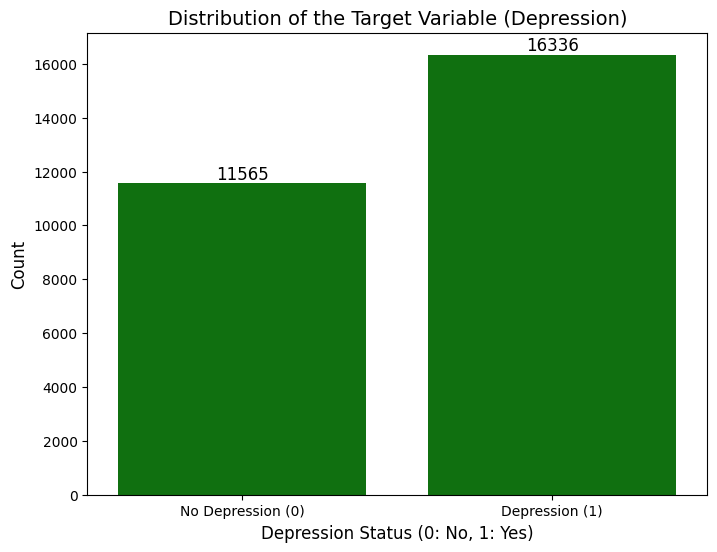

In [12]:
# Create the countplot for the 'Depression' target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Depression_Target', data=df, color='green')
plt.title('Distribution of the Target Variable (Depression)', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set custom x-tick labels for clarity
plt.xticks(ticks=[0, 1], labels=['No Depression (0)', 'Depression (1)'])

# Add counts on top of bars for exact numbers (optional but helpful)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
            '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.savefig('target_distribution.png', dpi=300)
plt.show()
plt.close()

In [13]:
display(df_encoded)

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression_Target,Gender_Encoded,...,Degree_MSc,Degree_Others,Degree_PhD,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours',Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy
0,33,5,0,8.97,2,0,3,1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,24,2,0,5.90,5,0,3,2.0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,31,3,0,7.03,5,0,9,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,28,3,0,5.59,2,0,4,5.0,1,1,...,0,0,0,1,0,0,0,1,0,0
4,25,4,0,8.13,3,0,1,1.0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,27,5,0,5.75,5,0,7,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
27897,27,2,0,9.40,3,0,0,3.0,0,0,...,1,0,0,0,1,0,0,0,0,0
27898,31,3,0,6.61,4,0,12,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
27899,18,5,0,6.88,2,0,10,5.0,1,1,...,0,0,0,0,1,0,0,0,0,0


**Feature selection using ANOVA F-test**

In [14]:
# Load the processed and encoded data
df_encoded = pd.read_csv('student_depression_dataset_encoded.csv')

# Define the target column name
target_col = 'Depression_Target'

# Prepare data for feature selection
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# --- CORRECTION: Add VarianceThreshold for Robustness ---
# Remove features with zero variance (prevents error in f_classif)
vt_selector = VarianceThreshold()
X_vt = vt_selector.fit_transform(X)
cols_after_vt = X.columns[vt_selector.get_support()]
X_vt = pd.DataFrame(X_vt, columns=cols_after_vt, index=X.index)


# Rerun Feature selection using ANOVA F-test (SelectKBest)
top_k = 10
selector = SelectKBest(score_func=f_classif, k=top_k)

# Fit the selector to the variance-filtered data
selector.fit(X_vt, y)

# Get F-scores and feature ranking
f_scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X_vt.columns, 'F_score': f_scores}).sort_values(
    by='F_score', ascending=False
)

# Print the top features and scores
print("\n--- Feature Ranking (ANOVA F-Score) ---")
print(feature_scores.head(top_k + 5).to_markdown(index=False))

# Select and Filter the DataFrame
selected_features = feature_scores['Feature'].head(top_k).tolist()
df_reduced = df_encoded[selected_features + [target_col]].copy()

print(f"\nTop {top_k} Selected Features: {selected_features}")
print(f"Reduced DataFrame shape: {df_reduced.shape}")

# Save the reduced DataFrame
df_reduced.to_csv('student_depression_dataset_feature_selection.csv', index=False)
print("Saved: student_depression_dataset_feature_selection.csv")


--- Feature Ranking (ANOVA F-Score) ---
| Feature                                      |    F_score |
|:---------------------------------------------|-----------:|
| Have_you_ever_had_suicidal_thoughts__Encoded | 11870.2    |
| Academic Pressure                            |  8123.75   |
| Financial Stress                             |  4256.14   |
| Age                                          |  1495.94   |
| Work/Study Hours                             |  1266.06   |
| Dietary Habits_Unhealthy                     |  1039.45   |
| Study Satisfaction                           |   810.921  |
| Sleep Duration_'More than 8 hours'           |   185.824  |
| Sleep Duration_'Less than 5 hours'           |   173.764  |
| Family_History_of_Mental_Illness_Encoded     |    80.2698 |
| Dietary Habits_Moderate                      |    40.8136 |
| Degree_M.Tech                                |    25.2384 |
| Degree_M.Ed                                  |    22.0953 |
| CGPA                       

**Balancing the dataset**

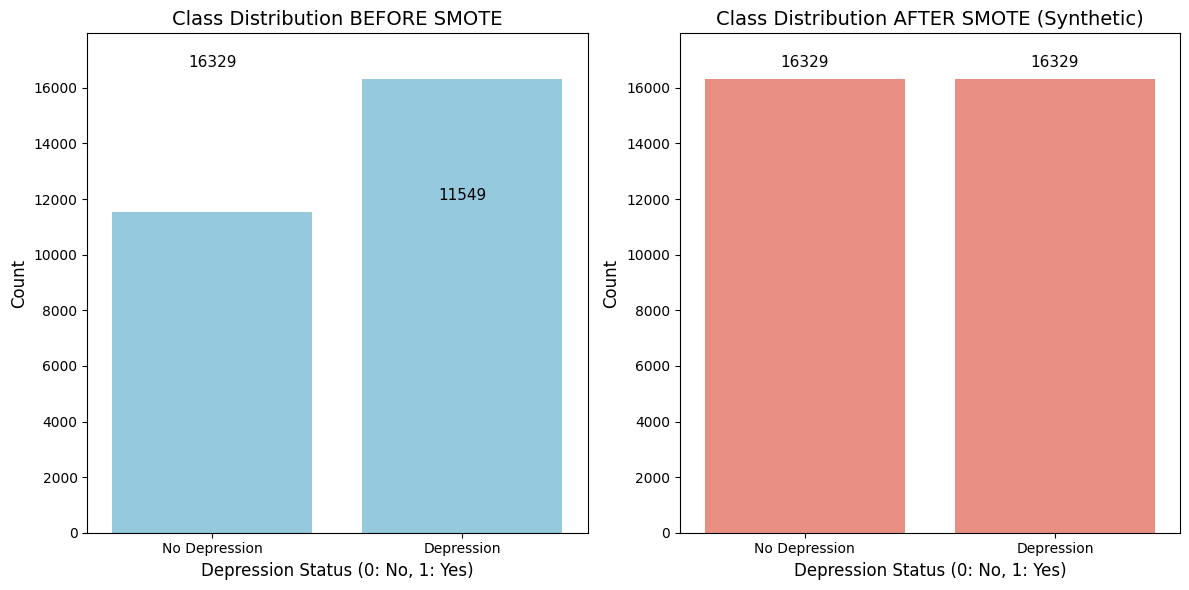

In [17]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define the target column name
target_col = 'Depression_Target'

# --- 1. Load Unbalanced Data (Before SMOTE) ---
# This file contains the feature-selected data, which is unbalanced.
df_unbalanced = pd.read_csv('student_depression_dataset_feature_selection.csv')
y_unbalanced = df_unbalanced[target_col] # Renamed for clarity
data_before = y_unbalanced.value_counts()

# --- 2. Load Balanced Data (After SMOTE) ---
# This file is assumed to be generated by the SMOTE code you ran previously.
df_balanced = pd.read_csv('student_depression_dataset_balanced.csv')
data_after = df_balanced[target_col].value_counts()

# Determine the maximum count for consistent y-axis scaling
max_count = max(data_before.max(), data_after.max())

# --- 3. Visualization Code ---

# Create Comparison Visualization
plt.figure(figsize=(12, 6))

# Subplot 1: Before SMOTE
plt.subplot(1, 2, 1)
sns.barplot(x=data_before.index, y=data_before.values, color='skyblue')
plt.title('Class Distribution BEFORE SMOTE', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Depression', 'Depression'])
plt.ylim(0, max_count * 1.1) # Set Y-axis limit

# Add counts on top of bars
for i, count in enumerate(data_before.values):
    plt.text(i, count + max_count * 0.02, str(count), ha='center', va='bottom', fontsize=11)

# Subplot 2: After SMOTE
plt.subplot(1, 2, 2)
sns.barplot(x=data_after.index, y=data_after.values, color='salmon')
plt.title('Class Distribution AFTER SMOTE (Synthetic)', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Depression', 'Depression'])
plt.ylim(0, max_count * 1.1) # Set Y-axis limit

# Add counts on top of bars
for i, count in enumerate(data_after.values):
    plt.text(i, count + max_count * 0.02, str(count), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('SMOTE_Class_Distribution_Comparison.png', dpi=300)
plt.show()

**Balancing the dataset using SMOTE**

In [18]:
from imblearn.over_sampling import SMOTE

# Load the feature-selected data
df_unbalanced = pd.read_csv('student_depression_dataset_feature_selection.csv')

# Define the target column name
target_col = 'Depression_Target'

# Prepare data for SMOTE
X = df_unbalanced.drop(columns=[target_col])
y = df_unbalanced[target_col]

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_balanced, y_balanced = smote.fit_resample(X, y)

# Combine the balanced features and target back into a DataFrame
df_balanced = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.DataFrame(y_balanced, columns=[target_col])], axis=1)

# Save the balanced dataset
df_balanced.to_csv('student_depression_dataset_balanced.csv', index=False)

print("Dataset balanced using SMOTE and saved as 'student_depression_dataset_balanced.csv'")
print(f"Balanced Dataset Shape: {df_balanced.shape}")
print(f"Balanced Class Distribution:\n{df_balanced[target_col].value_counts()}")

Dataset balanced using SMOTE and saved as 'student_depression_dataset_balanced.csv'
Balanced Dataset Shape: (32658, 11)
Balanced Class Distribution:
Depression_Target
1    16329
0    16329
Name: count, dtype: int64


### **TRAIN THE MODEL**

In [19]:
import pandas as pd

df = pd.read_csv("student_depression_dataset_balanced.csv")
print(df.shape)
df.head()


(32658, 11)


,Have_you_ever_had_suicidal_thoughts__Encoded,Academic Pressure,Financial Stress,Age,Work/Study Hours,Dietary Habits_Unhealthy,Study Satisfaction,Sleep Duration_'More than 8 hours',Sleep Duration_'Less than 5 hours',Family_History_of_Mental_Illness_Encoded,Depression_Target
0,1,5,1.0,33,3,0,2,0,0,0,1
1,0,2,2.0,24,3,0,5,0,0,1,0
2,0,3,1.0,31,9,0,5,0,1,1,0
3,1,3,5.0,28,4,0,2,0,0,1,1
4,1,4,1.0,25,1,0,3,0,0,0,0


Train: (26126, 10)  Test: (6532, 10)

Searching LinearSVC hyperparameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'svm__C': np.float64(63.512210106407046)}
Best CV F1: 0.8521

===== LinearSVC Test Performance =====
Accuracy : 0.8621
Precision: 0.8567
Recall   : 0.8696
F1-score : 0.8631
ROC-AUC  : 0.9315

              precision    recall  f1-score   support

           0     0.8676    0.8546    0.8610      3266
           1     0.8567    0.8696    0.8631      3266

    accuracy                         0.8621      6532
   macro avg     0.8621    0.8621    0.8621      6532
weighted avg     0.8621    0.8621    0.8621      6532



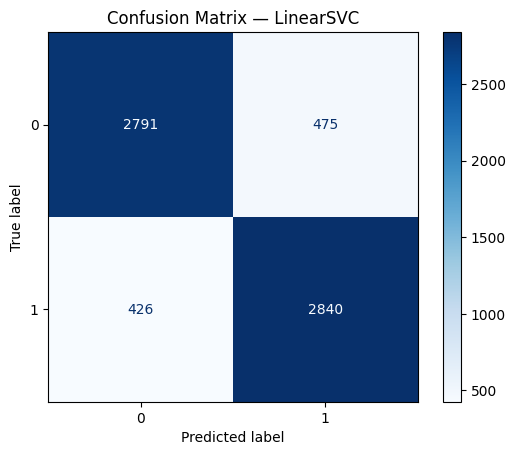

In [22]:
# ========================= SVM TRAINING  =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.svm import LinearSVC  # Changed from SVC to LinearSVC
from scipy.stats import loguniform, uniform
import warnings; warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# ---- 0) Get data from existing variables (preferred) or build from df/CSV ----
def find_target_column(columns):
    # pick the first column whose name contains "depress" (case-insensitive)
    cands = [c for c in columns if "depress" in c.lower()]
    if not cands:
        raise ValueError("No target column containing 'depress' found. Set TARGET manually.")
    return cands[0]

if 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals():
    # Reuse splits from the RF notebook
    pass
else:
    # Try to use an existing df; otherwise load from CSV saved earlier
    if 'df' not in globals():
        df = pd.read_csv("student_depression_dataset_balanced.csv")  # change if needed
    # Detect target
    TARGET = find_target_column(df.columns)
    y = df[TARGET].astype(int)
    X = df.drop(columns=[TARGET])
    # Split (match RF style: stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

print("Train:", X_train.shape, " Test:", X_test.shape)

# ---- 1) Preprocessing (same spirit as RF: impute + one-hot + scale) ----
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

# ---- 2) LinearSVC model + fast hyperparameter search (balanced) ----
svm_base = Pipeline([
    ("prep", preprocess),
    ("svm", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE, dual=True, max_iter=10000)) # Added dual=True and max_iter for convergence
])

param_dist = {
    # search on log scale; these ranges work well for tabular data
    "svm__C": loguniform(1e-2, 1e2),      # ~[0.01, 100]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)  # faster than 5-fold
search = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_dist,
    n_iter=12,                # quick but effective
    scoring="f1",             # good for imbalance
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

print("\nSearching LinearSVC hyperparameters...")
search.fit(X_train, y_train)
best_svm = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV F1:", round(search.best_score_, 4))

# ---- 3) Train final model on full train with best params ----
# (search already does refit=True by default; safest to call again explicitly)
best_svm.fit(X_train, y_train)

# ---- 4) Evaluate on untouched test set ----
# LinearSVC does not have predict_proba, use decision_function
y_scores = best_svm.decision_function(X_test)
y_pred  = (y_scores >= 0).astype(int) # Threshold at 0 for LinearSVC

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
# ROC-AUC with decision_function for LinearSVC
auc  = roc_auc_score(y_test, y_scores)

print("\n===== LinearSVC Test Performance =====")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix — LinearSVC")
plt.show()
# ======================= end SVM training block =======================


===== Test Performance (LinearSVC) =====
Accuracy : 0.8621
Precision: 0.8567
Recall   : 0.8696
F1-score : 0.8631
ROC-AUC  : 0.9315

              precision    recall  f1-score   support

           0     0.8676    0.8546    0.8610      3266
           1     0.8567    0.8696    0.8631      3266

    accuracy                         0.8621      6532
   macro avg     0.8621    0.8621    0.8621      6532
weighted avg     0.8621    0.8621    0.8621      6532



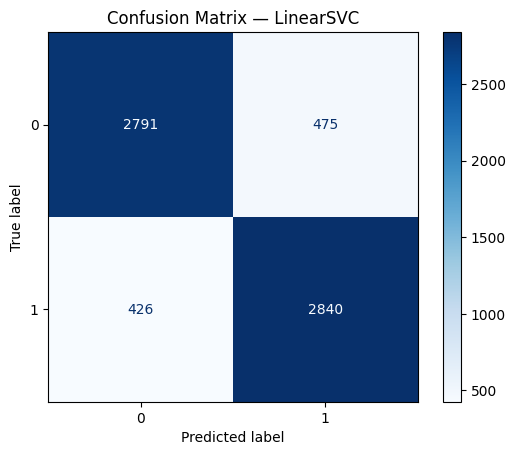

In [25]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             ConfusionMatrixDisplay)

# LinearSVC gives decision_function (scores). Threshold at 0.
scores_test = best_svm.decision_function(X_test)
y_pred = (scores_test >= 0).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, scores_test)

print("\n===== Test Performance (LinearSVC) =====")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix — LinearSVC")
plt.show()

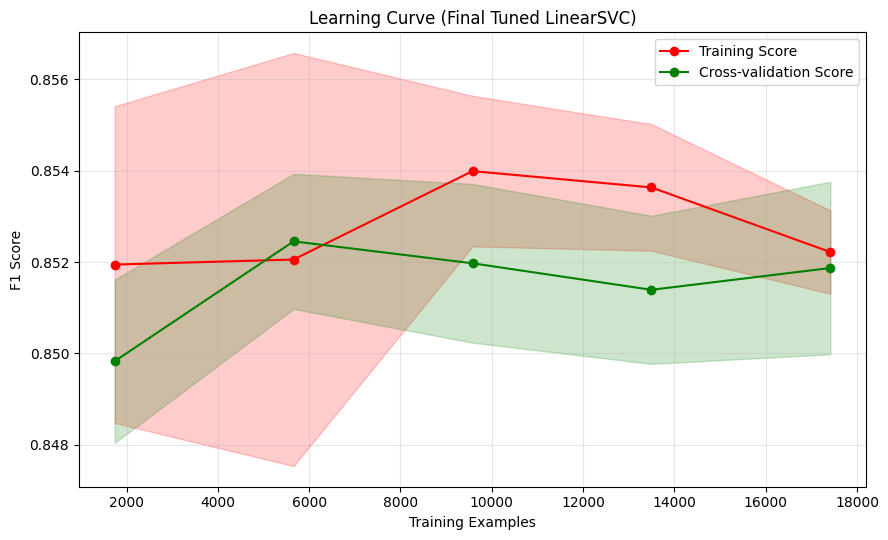

In [27]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, 5)
sizes, train_scores, val_scores = learning_curve(
    estimator=best_svm,   # uses the fitted preprocessing & tuned C
    X=X_train, y=y_train,
    train_sizes=train_sizes,
    cv=cv, scoring="f1",
    n_jobs=-1, shuffle=True, random_state=42
)

train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean,   val_std   = val_scores.mean(axis=1),   val_scores.std(axis=1)
abs_sizes = sizes.astype(int)

plt.figure(figsize=(9,5.5))
plt.plot(abs_sizes, train_mean, "o-", label="Training Score", color="red")
plt.fill_between(abs_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="red")
plt.plot(abs_sizes, val_mean, "o-", label="Cross-validation Score", color="green")
plt.fill_between(abs_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2, color="green")
plt.title("Learning Curve (Final Tuned LinearSVC)")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [33]:
import joblib
joblib.dump(best_svm, "svm_linear_tuned_pipeline.joblib")
print("Saved: svm_linear_tuned_pipeline.joblib")

Saved: svm_linear_tuned_pipeline.joblib


In [36]:
# ======== Simple UI for Depression Prediction (Gradio) ========
!pip -q install gradio

import gradio as gr
import pandas as pd
import numpy as np
import joblib

# 🔧 Change if different
MODEL_PATH = "svm_linear_tuned_pipeline.joblib"          # your saved pipeline (preprocess + LinearSVC)
TRAIN_CSV  = "student_depression_dataset_balanced.csv"   # same schema as the model was trained on

# 1) Load pipeline and training data (to infer inputs)
pipe = joblib.load(MODEL_PATH)
df_train = pd.read_csv(TRAIN_CSV)

# Find the target column (contains "depress")
target_col = next(c for c in df_train.columns if "depress" in c.lower())
X_train = df_train.drop(columns=[target_col])

# Build Gradio inputs automatically from training schema:
gr_inputs = []
column_order = []

for col in X_train.columns:
    column_order.append(col)
    s = X_train[col]
    if s.dtype.kind in "biufc":  # numeric
        # slider bounds from training data (with a little padding)
        vmin = float(np.nanmin(s))
        vmax = float(np.nanmax(s))
        # choose a reasonable step
        step = 1.0 if (vmax - vmin) > 10 else 0.1
        default = float(np.nanmedian(s))
        gr_inputs.append(
            gr.Slider(minimum=vmin, maximum=vmax, value=default, step=step, label=col)
        )
    else:
        # categorical -> dropdown of observed categories (sorted, unique)
        choices = sorted([str(x) for x in s.dropna().unique().tolist()])
        # pick the first as default (or set your preferred)
        default = choices[0] if choices else ""
        gr_inputs.append(
            gr.Dropdown(choices=choices, value=default, label=col)
        )

# 2) Predict function
def predict_fn(*vals):
    # vals come in the same order as gr_inputs / column_order
    data = {col: [val] for col, val in zip(column_order, vals)}
    X_new = pd.DataFrame(data)

    # LinearSVC: use decision_function (signed distance to boundary)
    # score > 0 ⇒ predict class 1 (Depression), else class 0 (No Depression)
    try:
        scores = pipe.decision_function(X_new)
        preds = (scores >= 0).astype(int)
        score = float(scores[0])
    except AttributeError:
        # If you later switch to an SVC with probability=True
        prob = pipe.predict_proba(X_new)[:,1]
        preds = (prob >= 0.5).astype(int)
        score = float(prob[0])

    label = "Depression" if preds[0] == 1 else "No Depression"
    # Make a friendly confidence-like message
    if 'decision_function' in dir(pipe):
        conf_msg = f"Decision score: {score:+.3f} (positive ⇒ more likely depression)"
    else:
        conf_msg = f"Predicted probability of depression: {score:.3f}"

    return label, conf_msg

# 3) Gradio UI
title = "Student Depression Predictor (SVM)"
desc  = (
    "Provide the required inputs (dropdowns for categories, sliders for numbers). "
    "The model will predict whether the student is at risk of depression."
)

demo = gr.Interface(
    fn=predict_fn,
    inputs=gr_inputs,
    outputs=[
        gr.Label(num_top_classes=2, label="Prediction"),
        gr.Textbox(label="Model Score / Confidence", show_copy_button=True)
    ],
    title=title,
    description=desc,
    allow_flagging="never",
)

demo.launch(debug=False)  # set share=True if you want a public link
# ================================================================


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://396d92e0a6613b43cd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [37]:
# ================== Evaluate SVM Model Accuracy ==================
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# 🔧 Update these if your file names are different
MODEL_PATH = "svm_linear_tuned_pipeline.joblib"
DATA_PATH = "student_depression_dataset_balanced.csv"

# 1️⃣ Load the model and dataset
model = joblib.load(MODEL_PATH)
df = pd.read_csv(DATA_PATH)

# 2️⃣ Auto-detect the target column (contains "depress")
target_col = next(c for c in df.columns if "depress" in c.lower())

# 3️⃣ Split the data (same way as during training)
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4️⃣ Predict using the trained model
try:
    y_scores = model.decision_function(X_test)
    y_pred = (y_scores >= 0).astype(int)
except AttributeError:
    # For models that use predict_proba instead (e.g., RandomForest, SVC)
    y_scores = model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores >= 0.5).astype(int)

# 5️⃣ Calculate all key metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_scores)

print("\n===== Final Model Evaluation (SVM) =====")
print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1-score : {f1:.4f}")
print(f"✅ ROC-AUC  : {auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 6️⃣ Optional: Return Accuracy only (for group comparison)
acc
# ================================================================



===== Final Model Evaluation (SVM) =====
✅ Accuracy : 0.8621
✅ Precision: 0.8567
✅ Recall   : 0.8696
✅ F1-score : 0.8631
✅ ROC-AUC  : 0.9315

Classification Report:

              precision    recall  f1-score   support

           0     0.8676    0.8546    0.8610      3266
           1     0.8567    0.8696    0.8631      3266

    accuracy                         0.8621      6532
   macro avg     0.8621    0.8621    0.8621      6532
weighted avg     0.8621    0.8621    0.8621      6532



0.8620636864666258